In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline
import random


In [2]:
cd /Users/austinmcdonald/Desktop/test/cut/

/Users/austinmcdonald/Desktop/test/cut


In [3]:
DataSet = os.listdir()
DataSet = [x for x in DataSet if x != '.DS_Store']
#DataSet = DataSet[0]
DataSet

['Ba', 'Ca', 'Na']

In [4]:
DataPath = '/Users/austinmcdonald/Desktop/test/cut'

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [6]:
eCoeff = 0.01160
eOffset= 1917
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREAPOST=dict()
AREASS=dict()
CHIR= dict()
CHIDIF=dict()
MEAND= dict()
MEANI=dict()
MEANE=dict()
CHISQUARE=dict()
CHILINE=dict()
NUM=dict()
ERRORS=dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    MASTERareaPost=[]
    MASTERmeanI=[]
    MASTERmeanE=[]
    MASTERchiDiff=[]
    MASTERchiSQUARE=[]
    MASTERchiLINE=[]
    MASTERERROR=[]
    SPOTS=[]

    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        for x in range(700,750):
            Images = np.array(Image.open(folder+'/'+files[x]))
            Images = eCoeffM*(Images - eOffsetM)
            #Mfit = np.zeros(len(xvs)) # kill this ?
            ImageFit = []
            for y in range(0,Shape):
                coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
                ffit  = poly.polyval(xvs, coefs)
                ImageFit.append(ffit)
            MeanFit+=np.array(ImageFit)
        MeanFit = MeanFit/50


        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            DataSub += Images


        data = DataSub

        threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 


        Images = None
        ImageB = None
        #data   = None
        Slices = None
        labeled= None
        num_objects=None

        ############################################################## 
        Xc=[]
        Yc=[]
        for qw in range(0,len(AllPairs)):
            XX = AllPairs[qw][0]
            YY = AllPairs[qw][1]
            if XX>10 and XX<210 and YY>10 and YY<210:
                Xc.append(XX)
                Yc.append(YY)
                

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(Xc)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        sigmas = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
            vals =np.arange(0,len(aa))
            
            sigmas.append(np.sqrt(np.array(aa)))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit*(25/56))

            meanI = np.mean(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,20):
                meanI = np.mean(Signal[x][:int(TauH)-Offset])
                meanE = np.mean(Signal[x][int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,20):
                meanI = np.mean(Signal[x][:int(TauH)-Offset])
                meanE = np.mean(Signal[x][int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        chiSQUAR = []
        chiLINE = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        chiDiff = []
        Offset =3
        NUMBER = 0
        errors=[]
        for x in range(0,Par):
            TauH   = Tau3[x]
            if TauH>0 and TauH<150:
                
                Data = Signal[x] 
                DataLeft  = Data[:int(TauH)-Offset]
                DataRight = Data[int(TauH)+Offset:]
                sigmasLeft  = sigmas[x][:int(TauH)-Offset]
                sigmasRight = sigmas[x][int(TauH)+Offset:]
                mean  = np.mean(Data)
                meanI  = np.mean(DataLeft)
                meanE  = np.mean(DataRight)


                chiHIGH = np.sum((DataLeft - meanI)**2/abs(sigmasLeft)**2)/749
                chiLOW = np.sum((DataRight - meanE)**2/abs(sigmasRight)**2)/749

                val = np.arange(0,len(Data),1)
                coefs=np.polyfit(val,Data,1)    
                ffit  = coefs[0]*val+coefs[1]
                chiFit  = np.sum((ffit - Data)**2/abs(sigmas[x])**2)/748



                if meanI-meanE>70 and ((chiLOW+chiHIGH) - chiFit)<-0.75:
                    NUMBER += 1

                chiRa.append((chiLOW+chiHIGH)/ chiFit)
                meanDif.append(meanI-meanE)
                areaS.append(ffit)
                areaSS.append(Data)
                areaPre.append(DataLeft)
                areaPost.append(DataRight)
                MeanI.append(meanI)
                MeanE.append(meanE)
                errors.append(sigmas[x])
                chiDiff.append((chiLOW+chiHIGH) - chiFit)
                chiSQUAR.append(chiLOW+chiHIGH)
                chiLINE.append(chiFit)
            
        SPOTS.append(NUMBER)
        MASTERTau.append(Tau3)
        MASTERarea.append(areaS)
        MASTERareaSS.append(areaSS)
        MASTERareaPre.append(areaPre)
        MASTERareaPost.append(areaPost)
        MASTERchiRa.append(chiRa)
        MASTERmeanD.append(meanDif)
        MASTERmeanI.append(MeanI)
        MASTERmeanE.append(MeanE)
        MASTERchiDiff.append(chiDiff)
        MASTERchiSQUARE.append(chiSQUAR)
        MASTERchiLINE.append(chiLINE)
        MASTERERROR.append(errors)
        
    ERRORS[z]    = [item for sublist in MASTERERROR for item in sublist] 
    MEANI[z]    = [item for sublist in MASTERmeanI for item in sublist] 
    MEANE[z]    = [item for sublist in MASTERmeanE for item in sublist]
    LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    AREASS[z]   = [item for sublist in MASTERareaSS for item in sublist]

    CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    CHIDIF[z]   = [item for sublist in MASTERchiDiff for item in sublist]
    MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]
    CHISQUARE[z]= [item for sublist in MASTERchiSQUARE for item in sublist]
    CHILINE[z]  = [item for sublist in MASTERchiLINE for item in sublist]
    NUM[z]      =  SPOTS


Finding all areas in dataset 2
Finding all areas in folder 21
On file 750 of 750


In [39]:
Xc=[]
Yc=[]
for ah in range(0,150):
    Xc.append(random.randint(10,210))
    Yc.append(random.randint(10,210))
len(Xc)

150

In [40]:
eCoeff = 0.01160
eOffset= 1917
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREAPOST=dict()
AREASS=dict()
CHIR= dict()
CHIDIF=dict()
MEAND= dict()
MEANI=dict()
MEANE=dict()
CHISQUARE=dict()
CHILINE=dict()
NUM=dict()
ERRORS=dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    MASTERareaPost=[]
    MASTERmeanI=[]
    MASTERmeanE=[]
    MASTERchiDiff=[]
    MASTERchiSQUARE=[]
    MASTERchiLINE=[]
    MASTERERROR=[]
    SPOTS=[]

    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        
        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(Xc)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        sigmas = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
            vals =np.arange(0,len(aa))
            
            sigmas.append(np.sqrt(np.array(aa)))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit*(25/56))

            meanI = np.mean(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,20):
                meanI = np.mean(Signal[x][:int(TauH)-Offset])
                meanE = np.mean(Signal[x][int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,20):
                meanI = np.mean(Signal[x][:int(TauH)-Offset])
                meanE = np.mean(Signal[x][int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        chiSQUAR = []
        chiLINE = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        chiDiff = []
        Offset =3
        NUMBER = 0
        errors=[]
        for x in range(0,Par):
            TauH   = Tau3[x]
            if TauH>0 and TauH<150:
                
                Data = Signal[x] 
                DataLeft  = Data[:int(TauH)-Offset]
                DataRight = Data[int(TauH)+Offset:]
                sigmasLeft  = sigmas[x][:int(TauH)-Offset]
                sigmasRight = sigmas[x][int(TauH)+Offset:]
                mean  = np.mean(Data)
                meanI  = np.mean(DataLeft)
                meanE  = np.mean(DataRight)


                chiHIGH = np.sum((DataLeft - meanI)**2/abs(sigmasLeft)**2)/749
                chiLOW = np.sum((DataRight - meanE)**2/abs(sigmasRight)**2)/749

                val = np.arange(0,len(Data),1)
                coefs=np.polyfit(val,Data,1)    
                ffit  = coefs[0]*val+coefs[1]
                chiFit  = np.sum((ffit - Data)**2/abs(sigmas[x])**2)/748



                if meanI-meanE>100 and ((chiLOW+chiHIGH) - chiFit)<1:
                    NUMBER += 1

                chiRa.append((chiLOW+chiHIGH)/ chiFit)
                meanDif.append(meanI-meanE)
                areaS.append(ffit)
                areaSS.append(Data)
                areaPre.append(DataLeft)
                areaPost.append(DataRight)
                MeanI.append(meanI)
                MeanE.append(meanE)
                errors.append(sigmas[x])
                chiDiff.append((chiLOW+chiHIGH) - chiFit)
                chiSQUAR.append(chiLOW+chiHIGH)
                chiLINE.append(chiFit)
            
        SPOTS.append(NUMBER)
        MASTERTau.append(Tau3)
        MASTERarea.append(areaS)
        MASTERareaSS.append(areaSS)
        MASTERareaPre.append(areaPre)
        MASTERareaPost.append(areaPost)
        MASTERchiRa.append(chiRa)
        MASTERmeanD.append(meanDif)
        MASTERmeanI.append(MeanI)
        MASTERmeanE.append(MeanE)
        MASTERchiDiff.append(chiDiff)
        MASTERchiSQUARE.append(chiSQUAR)
        MASTERchiLINE.append(chiLINE)
        MASTERERROR.append(errors)
        
    ERRORS[z]    = [item for sublist in MASTERERROR for item in sublist] 
    MEANI[z]    = [item for sublist in MASTERmeanI for item in sublist] 
    MEANE[z]    = [item for sublist in MASTERmeanE for item in sublist]
    LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    AREASS[z]   = [item for sublist in MASTERareaSS for item in sublist]

    CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    CHIDIF[z]   = [item for sublist in MASTERchiDiff for item in sublist]
    MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]
    CHISQUARE[z]= [item for sublist in MASTERchiSQUARE for item in sublist]
    CHILINE[z]  = [item for sublist in MASTERchiLINE for item in sublist]
    NUM[z]      =  SPOTS


Finding all areas in dataset 2
Finding all areas in folder 21
On file 750 of 750


In [125]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' pairs = ',len(LIFETIME[x]))

Ba  pairs =  3300
Ca  pairs =  150
Na  pairs =  3300


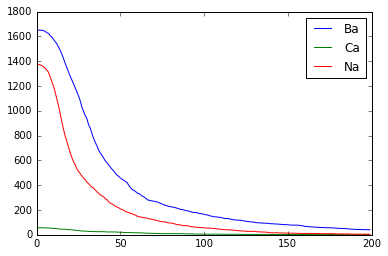

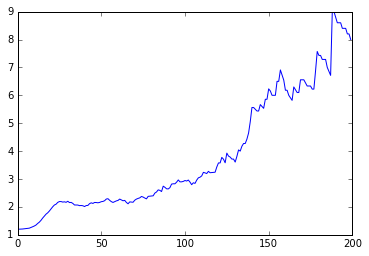

In [31]:
Signals=dict()
Backs=dict()
test=np.arange(1,200,1)
SigsAll=[]
for x in range(0,len(DataSet)):
    Sigs=[]
    for p in range(0,len(test)):
        Sig=0
        for z in range(0,len(CHISQUARE[x])):
            if MEAND[x][z]>test[p] :#and MEAND[x][z]>100:
                Sig=Sig+1
        Sigs.append(Sig)
    plt.plot(test,Sigs,label=DataSet[x])
    SigsAll.append(Sigs)
plt.legend(loc='upper right')
plt.show()
plt.plot(test,SigsAll[0]/np.array(SigsAll[2]))

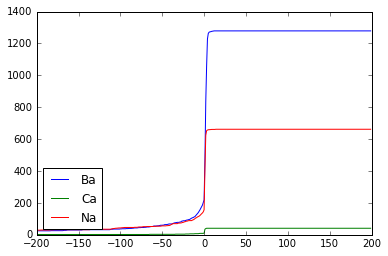

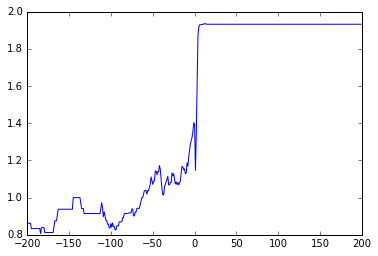

In [32]:
Signals=dict()
Backs=dict()
test=np.arange(-200,200,1)
SigsAll=[]
for x in range(0,len(DataSet)):
    Sigs=[]
    for p in range(0,len(test)):
        Sig=0
        for z in range(0,len(CHISQUARE[x])):
            if CHIDIF[x][z]<test[p] and MEAND[x][z]>20:
                Sig=Sig+1
        Sigs.append(Sig)
    plt.plot(test,Sigs,label=DataSet[x])
    SigsAll.append(Sigs)
plt.legend(loc='lower left')
plt.show()
plt.plot(test,SigsAll[0]/np.array(SigsAll[2]))

In [130]:
len(CHIDIF[0])

2072

In [53]:
CHISQUARE[0][4]

1822.1193095307208

In [54]:
CHILINE[0][4]

241.33746608223191

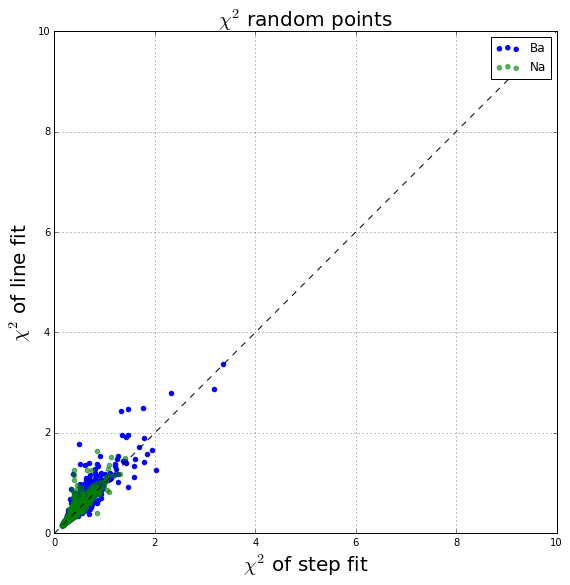

In [48]:
plt.figure(figsize=(9,9))
plt.scatter(CHISQUARE[0],CHILINE[0],color='b',label=DataSet[0])
plt.scatter(CHISQUARE[2],CHILINE[2],color='g',label=DataSet[2],alpha=0.6)
plt.title(r'$\chi^2$ random points',fontsize=20)
vars=np.arange(0,15,1)
plt.plot(vars,vars,'--',color='black')
plt.xlabel(r"$\chi^2$ of step fit",fontsize=20)
plt.ylabel(r"$\chi^2$ of line fit",fontsize=20)
plt.legend()
plt.xlim(0,10)
plt.ylim(0,10)
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chiRAND')
plt.show()

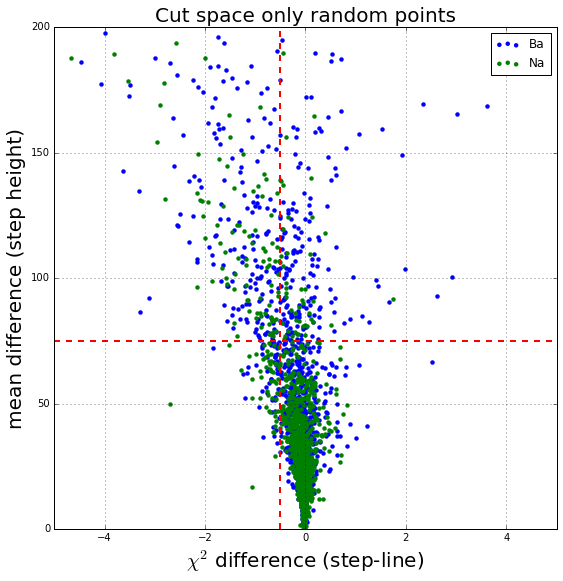

In [7]:
plt.figure(figsize=(9,9))
plt.scatter(CHIDIF[0],MEAND[0],color='b',label=DataSet[0],linewidth=0.001)
plt.scatter(CHIDIF[2],MEAND[2],color='g',label=DataSet[2],linewidth=0.001)
plt.title(r'Cut space only random points',fontsize=20)

plt.xlabel(r"$\chi^2$ difference (step-line)",fontsize=20)
plt.ylabel("mean difference (step height)",fontsize=20)
plt.legend()
plt.xlim(-5,5)
plt.ylim(0,200)
plt.axhline(75,linewidth=2,linestyle='--',color='r')
plt.axvline(-0.5,linewidth=2,linestyle='--',color='r')
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chiRAND-cut')
plt.show()

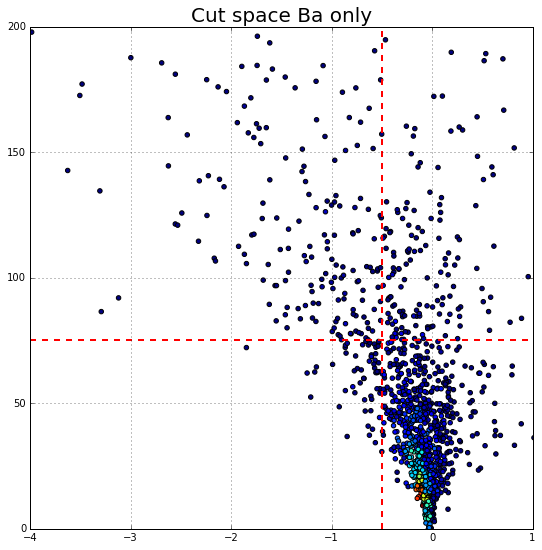

In [38]:
plt.figure(figsize=(9,9))
#x = CHIDIF[0]
#y = MEAND[0]
bins = 70
plt.title(r'Cut space Ba only',fontsize=20)

xedges, yedges = np.linspace(-4, 1, bins), np.linspace(0, 200, bins)
hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
plt.scatter(x, y, c=c)
plt.xlim(-4,1)
plt.ylim(0,200)
plt.axhline(75,linewidth=2,linestyle='--',color='r')
plt.axvline(-0.5,linewidth=2,linestyle='--',color='r')
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chiba-cut')
plt.show()

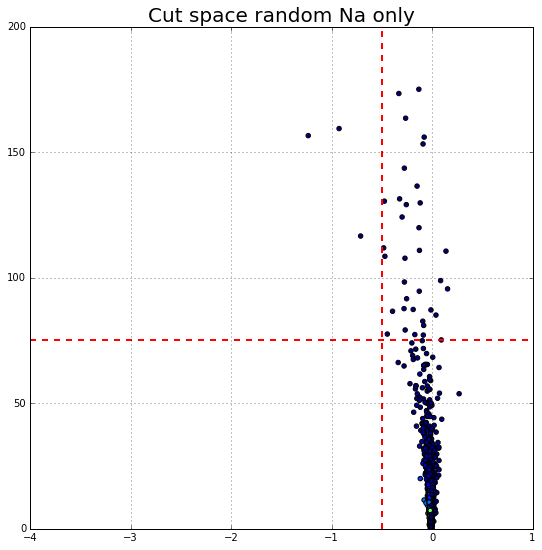

In [44]:
plt.figure(figsize=(9,9))
x2 = CHIDIF[2]
y2 = MEAND[2]
bins = 70
plt.title(r'Cut space random Na only',fontsize=20)

xedges, yedges = np.linspace(-4, 1, bins), np.linspace(0, 200, bins)
hist, xedges, yedges = np.histogram2d(x2, y2, (xedges, yedges))
xidx = np.clip(np.digitize(x2, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(y2, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
plt.scatter(x2, y2, c=c)
plt.xlim(-4,1)
plt.ylim(0,200)
plt.axhline(75,linewidth=2,linestyle='--',color='r')
plt.axvline(-0.5,linewidth=2,linestyle='--',color='r')
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chinaRAND-cut')
plt.show()

In [87]:
x4 = CHIDIF[2]
y4 = MEAND[2]

In [91]:
def isNaN(num):
    return num != num
chk = y4
te=[]
for a in range(0,len(chk)):
    if chk[a]!=chk[a]:
        te.append(1)
len(te)

0

In [90]:
y4 = np.nan_to_num(y4)

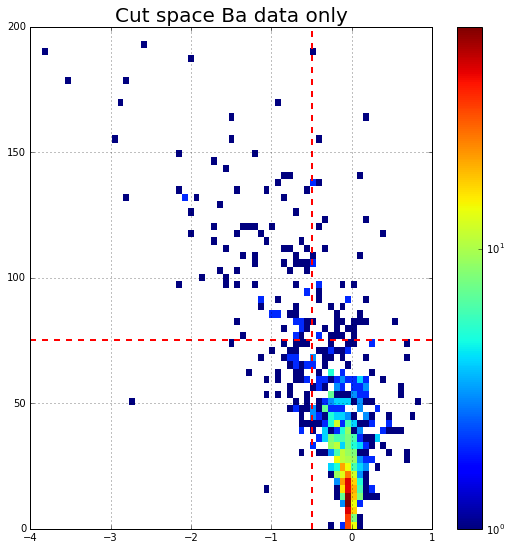

In [97]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
bins = 70

plt.figure(figsize=(9,9))

plt.title(r'Cut space Ba data only',fontsize=20)

xedges, yedges = np.linspace(-4, 1, bins), np.linspace(0, 200, bins)
plt.hist2d(x4, y4, bins=(xedges, yedges), norm=LogNorm())
plt.colorbar()
plt.xlim(-4,1)
plt.ylim(0,200)
plt.axhline(75,linewidth=2,linestyle='--',color='r')
plt.axvline(-0.5,linewidth=2,linestyle='--',color='r')
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chiBadata-cut')
plt.show()

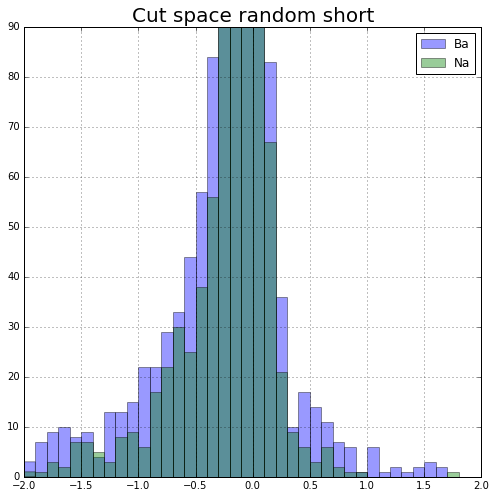

In [136]:
plt.figure(figsize=(7,7))
num =0.1
plt.title(r'Cut space random short',fontsize=20)
plt.hist(CHIDIF[0],label=DataSet[0],alpha=0.4,color='b',bins=np.arange(-2,2,num))
plt.hist(CHIDIF[2],label=DataSet[2],alpha=0.4,color='g',bins=np.arange(-2,2,num))
plt.xlim(-2,2)
plt.ylim(0,90)
plt.legend()
plt.tight_layout()
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chihistRAND-cutwhole')
plt.show()

In [47]:
np.isnan(x2)

array([False, False, False, ..., False, False, False], dtype=bool)

In [50]:
def isNaN(num):
    return num != num
chk = y2
te=[]
for a in range(0,len(chk)):
    if chk[a]!=chk[a]:
        te.append(1)
len(te)

100

In [51]:
y3 = np.nan_to_num(y2)

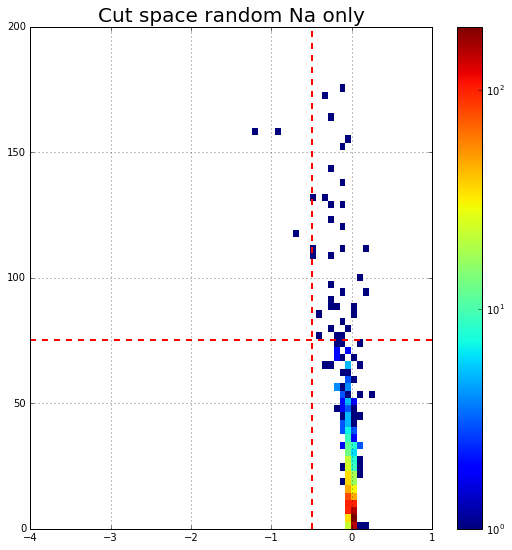

In [85]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
plt.figure(figsize=(9,9))

plt.title(r'Cut space random Na only',fontsize=20)

xedges, yedges = np.linspace(-4, 1, bins), np.linspace(0, 200, bins)
plt.hist2d(x2, y3, bins=(xedges, yedges), norm=LogNorm())
plt.colorbar()
plt.xlim(-4,1)
plt.ylim(0,200)
plt.axhline(75,linewidth=2,linestyle='--',color='r')
plt.axvline(-0.5,linewidth=2,linestyle='--',color='r')
plt.grid(True)
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/'+'chinaRAND-cut')
plt.show()

In [120]:
lifetime=dict()
for x in range(0,len(DataSet)):
    LT=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>70 and CHIDIF[x][z]<-0.75:#CHISQUARE[x][z]<CHILINE[x][z] :#and MEANE[x][z]<20:
      
            LT.append(LIFETIME[x][z])
    lifetime[x]=LT# = [item for sublist in LT for item in sublist]
print('Ba Passes Cuts = ',len(lifetime[0]))
print('Na Passes Cuts = ',len(lifetime[2]))
print('sigma = ',(len(lifetime[0])-len(lifetime[2]))/np.sqrt(len(lifetime[2])))

Ba Passes Cuts =  187
Na Passes Cuts =  75
sigma =  12.9326460298


In [41]:
lifetime=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>60 and CHIR[x][z]<1 :#and MEANE[x][z]<20:
      
            LT.append(LIFETIME[x][z])
    lifetime[x]=LT# = [item for sublist in LT for item in sublist]
print('Ba Passes Cuts = ',len(lifetime[0]))
print('Na Passes Cuts = ',len(lifetime[2]))
print('sigma = ',(len(lifetime[0])-len(lifetime[2]))/np.sqrt(len(lifetime[2])))

Ba Passes Cuts =  150
Na Passes Cuts =  77
sigma =  8.31912208155


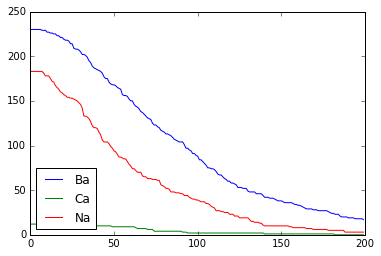

[0]


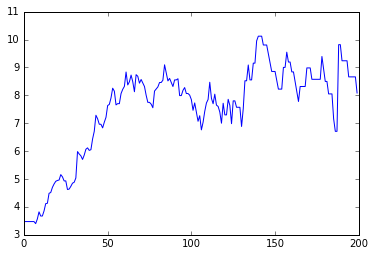

In [37]:
Signals=dict()
Backs=dict()
test=np.arange(0,200,1)
SigsAll=[]
for x in range(0,len(DataSet)):
    Sigs=[]
    for p in range(0,len(test)):
        Sig=0
        for z in range(0,len(CHISQUARE[x])):
            if CHISQUARE[x][z]<CHILINE[x][z] and MEAND[x][z]>test[p]:
                Sig=Sig+1
        Sigs.append(Sig)
    plt.plot(test,Sigs,label=DataSet[x])
    SigsAll.append(Sigs)
plt.legend(loc='lower left')
plt.show()
S1=np.array(SigsAll[0])
S2=np.array(SigsAll[2])
plt.plot(test,(S1-S2)/np.sqrt(S2))
ah = np.where(max((S1-S2)/np.sqrt(S2)))
print(test[ah])
plt.show()

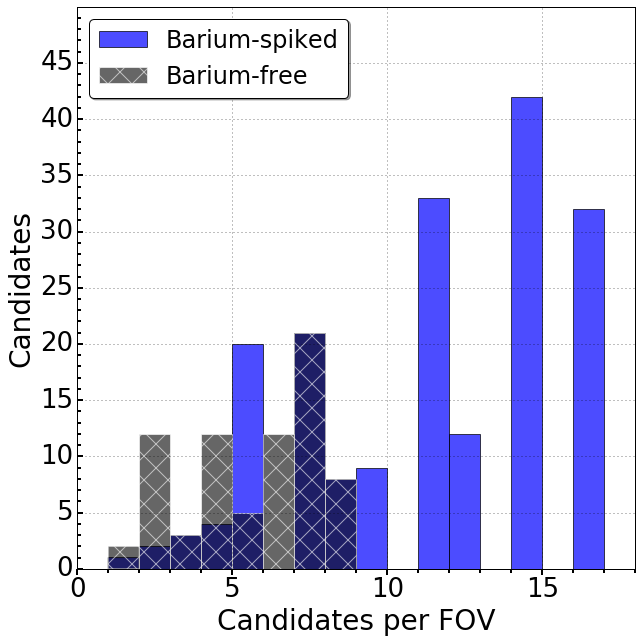

In [8]:

fig, ax = plt.subplots(figsize=(9,9))
num =1

s1 = ax.hist(NUM[0],label='Barium-spiked',alpha=0.7,color='blue',bins=np.arange(1,21,num),weights=NUM[0])
b1 = ax.hist(NUM[2],label='Barium-free',alpha=0.6,color='k',bins=np.arange(1,21,num),weights=NUM[2],edgecolor='w', hatch="x")

ax.set_xlabel('Candidates per FOV', fontsize=28)
ax.set_ylabel('Candidates', fontsize=28)

#handles,labels = ax.get_legend_handles_labels()
#handles = [handles[3], handles[1], handles[2], handles[0]]
#labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(loc='upper left',fontsize=24,shadow=True, fancybox=True)

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 21, 5)
xminor_ticks = np.arange(0, 21, 1)
ymajor_ticks = np.arange(0, 50, 5)
yminor_ticks = np.arange(0, 50, 1)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=2,length=4,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,18)
ax.set_ylim(0,50)
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/fitting/Ba-FOV-V3.png')
plt.show()